# Options Pricing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.optimize import newton
from functools import partial
from typing import Callable, Tuple, Union, List

In [3]:
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [10, 6]

In [4]:
# Type aliases for better readability
OptionType = str
GreekFunction = Callable[[float, float, float, float, float, OptionType], float]
PricingFunction = Callable[[float, float, float, float, float, OptionType], float]

In [5]:
def validate_option_type(option_type: OptionType) -> None:
    """Validate that option type is either 'call' or 'put'"""
    if option_type.lower() not in ['call', 'put']:
        raise ValueError("Option type must be 'call' or 'put'")

In [6]:
def calculate_d1(S: float, K: float, T: float, r: float, sigma: float) -> float:
    """Calculate d1 parameter for Black-Scholes model"""
    return (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

In [7]:
def black_scholes_price(S: float, K: float, T: float, r: float, sigma: float, 
                       option_type: OptionType = 'call') -> float:
    """Calculate option price using Black-Scholes formula"""
    validate_option_type(option_type)
    
    d1 = calculate_d1(S, K, T, r, sigma)
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

In [8]:
def binomial_tree_price(S: float, K: float, T: float, r: float, sigma: float, 
                       option_type: OptionType = 'call', steps: int = 100) -> float:
    """Calculate option price using binomial tree model"""
    validate_option_type(option_type)
    
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    
    # Initialize price tree
    price_tree = np.zeros((steps + 1, steps + 1))
    
    # Fill the terminal node prices
    for j in range(steps + 1):
        ST = S * (u ** (steps - j)) * (d ** j)
        price_tree[j, steps] = max(0, ST - K) if option_type == 'call' else max(0, K - ST)
    
    # Backward induction
    for i in range(steps - 1, -1, -1):
        for j in range(i + 1):
            price_tree[j, i] = np.exp(-r * dt) * (
                p * price_tree[j, i + 1] + (1 - p) * price_tree[j + 1, i + 1])
    
    return price_tree[0, 0]

In [9]:
def calculate_delta(S: float, K: float, T: float, r: float, sigma: float, 
                   option_type: OptionType) -> float:
    """Calculate option delta"""
    d1 = calculate_d1(S, K, T, r, sigma)
    return norm.cdf(d1) if option_type == 'call' else norm.cdf(d1) - 1

In [10]:
def calculate_gamma(S: float, K: float, T: float, r: float, sigma: float, 
                    option_type: OptionType) -> float:
    """Calculate option gamma"""
    d1 = calculate_d1(S, K, T, r, sigma)
    return norm.pdf(d1) / (S * sigma * np.sqrt(T))

In [11]:
def calculate_theta(S: float, K: float, T: float, r: float, sigma: float, 
                    option_type: OptionType) -> float:
    """Calculate option theta (per day)"""
    d1 = calculate_d1(S, K, T, r, sigma)
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        theta = - (S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) - \
                r * K * np.exp(-r * T) * norm.cdf(d2)
    else:
        theta = - (S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) + \
                r * K * np.exp(-r * T) * norm.cdf(-d2)
    
    return theta / 365  # Convert to daily theta

In [12]:
def calculate_vega(S: float, K: float, T: float, r: float, sigma: float, 
                   option_type: OptionType) -> float:
    """Calculate option vega (per 1% vol change)"""
    d1 = calculate_d1(S, K, T, r, sigma)
    return S * norm.pdf(d1) * np.sqrt(T) * 0.01

In [13]:
def calculate_rho(S: float, K: float, T: float, r: float, sigma: float, 
                  option_type: OptionType) -> float:
    """Calculate option rho (per 1% rate change)"""
    d1 = calculate_d1(S, K, T, r, sigma)
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        return K * T * np.exp(-r * T) * norm.cdf(d2) * 0.01
    else:
        return -K * T * np.exp(-r * T) * norm.cdf(-d2) * 0.01

In [14]:
def calculate_implied_volatility(market_price: float, S: float, K: float, T: float, 
                                r: float, option_type: OptionType) -> float:
    """Calculate implied volatility using Newton-Raphson method"""
    def f(sigma: float) -> float:
        return black_scholes_price(S, K, T, r, sigma, option_type) - market_price
    
    try:
        return newton(f, 0.2)  # Start with 20% as initial guess
    except RuntimeError:
        return np.nan

In [15]:
def plot_payoff_diagram(S: float, K: float, T: float, r: float, sigma: float, 
                        option_type: OptionType, min_S: float = 50, max_S: float = 150, 
                        points: int = 100) -> None:
    """Plot option payoff diagram"""
    validate_option_type(option_type)
    
    S_range = np.linspace(min_S, max_S, points)
    payoff = np.maximum(S_range - K, 0) if option_type == 'call' else np.maximum(K - S_range, 0)
    intrinsic = payoff.copy()
    current_price = black_scholes_price(S, K, T, r, sigma, option_type)
    
    plt.figure()
    plt.plot(S_range, payoff, label='Payoff at expiration', lw=2)
    plt.plot(S_range, intrinsic, '--', label='Intrinsic value', alpha=0.7)
    plt.axhline(y=current_price, color='r', linestyle=':', 
                label=f'Current price: {current_price:.2f}')
    
    plt.title(f'{option_type.capitalize()} Option Payoff Diagram (K={K})')
    plt.xlabel('Underlying Asset Price')
    plt.ylabel('Option Value')
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
def plot_greek_sensitivity(greek_func: GreekFunction, S: float, K: float, T: float, 
                          r: float, sigma: float, option_type: OptionType,
                          param: str = 'S', param_range: Union[np.ndarray, None] = None,
                          points: int = 100) -> None:
    """Plot sensitivity of a Greek to a parameter"""
    validate_option_type(option_type)
    
    if param_range is None:
        original_value = locals()[param]
        if param == 'S':
            param_range = np.linspace(0.5 * original_value, 1.5 * original_value, points)
        elif param == 'T':
            param_range = np.linspace(0.01, 2 * original_value, points)
        elif param == 'sigma':
            param_range = np.linspace(0.01, 0.5, points)
        elif param == 'r':
            param_range = np.linspace(0.001, 0.1, points)
        else:
            raise ValueError(f"Unsupported parameter: {param}")
    
    greek_values = []
    params = {'S': S, 'K': K, 'T': T, 'r': r, 'sigma': sigma, 'option_type': option_type}
    
    for val in param_range:
        params[param] = val
        greek_values.append(greek_func(**params))
    
    plt.figure()
    plt.plot(param_range, greek_values, lw=2)
    plt.title(f'{greek_func.__name__.replace("calculate_", "").capitalize()} Sensitivity to {param.upper()}')
    plt.xlabel(param.upper())
    plt.ylabel(greek_func.__name__.replace("calculate_", "").capitalize())
    plt.grid(True)
    plt.show()

In [17]:
def plot_volatility_surface(S: float, K: float, T_range: np.ndarray, r: float, 
                           option_type: OptionType = 'call') -> None:
    """Plot 3D volatility surface"""
    validate_option_type(option_type)
    
    # Create grid of strikes and maturities
    strikes = np.linspace(0.7 * S, 1.3 * S, 20)
    maturities = T_range if T_range is not None else np.linspace(0.1, 2, 20)
    K_grid, T_grid = np.meshgrid(strikes, maturities)
    
    # Calculate implied volatilities (simplified for demonstration)
    iv_surface = 0.2 + 0.3 * (K_grid - S) / S + 0.1 * np.log(T_grid)
    iv_surface = np.clip(iv_surface, 0.05, 0.8)
    
    # Calculate option prices
    prices = np.zeros_like(K_grid)
    for i in range(K_grid.shape[0]):
        for j in range(K_grid.shape[1]):
            prices[i,j] = black_scholes_price(S, K_grid[i,j], T_grid[i,j], r, iv_surface[i,j], option_type)
    
    # Create 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(K_grid, T_grid, prices, cmap='viridis', edgecolor='none')
    
    ax.set_xlabel('Strike Price')
    ax.set_ylabel('Time to Maturity (years)')
    ax.set_zlabel('Option Price')
    ax.set_title(f'{option_type.capitalize()} Option Price Surface')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

In [18]:
def create_greeks_report(S: float, K: float, T: float, r: float, sigma: float, 
                        option_type: OptionType) -> dict:
    """Create a dictionary with all Greeks for the option"""
    return {
        'delta': calculate_delta(S, K, T, r, sigma, option_type),
        'gamma': calculate_gamma(S, K, T, r, sigma, option_type),
        'theta': calculate_theta(S, K, T, r, sigma, option_type),
        'vega': calculate_vega(S, K, T, r, sigma, option_type),
        'rho': calculate_rho(S, K, T, r, sigma, option_type)
    }

In [19]:
def compare_pricing_methods(S: float, K: float, T: float, r: float, sigma: float, 
                           option_type: OptionType, steps: int = 100) -> dict:
    """Compare Black-Scholes and Binomial Tree pricing methods"""
    return {
        'black_scholes': black_scholes_price(S, K, T, r, sigma, option_type),
        'binomial_tree': binomial_tree_price(S, K, T, r, sigma, option_type, steps),
        'difference': abs(black_scholes_price(S, K, T, r, sigma, option_type) - 
                         binomial_tree_price(S, K, T, r, sigma, option_type, steps))
    }

Call Price (Black-Scholes): 10.45
Put Price (Black-Scholes): 5.57
Call Price (Binomial Tree): 10.43
Put Price (Binomial Tree): 5.55

Call Option Greeks:
Delta: 0.6368
Gamma: 0.0188
Theta: -0.0176
Vega: 0.3752
Rho: 0.5323


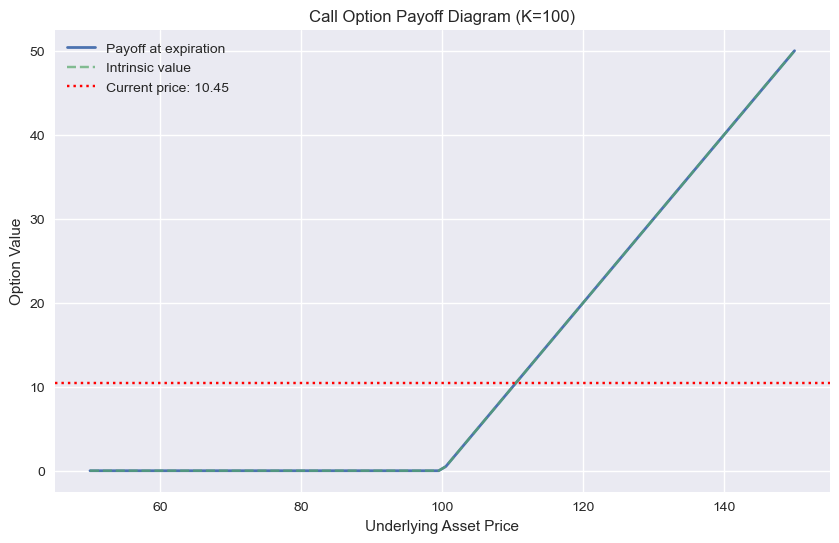

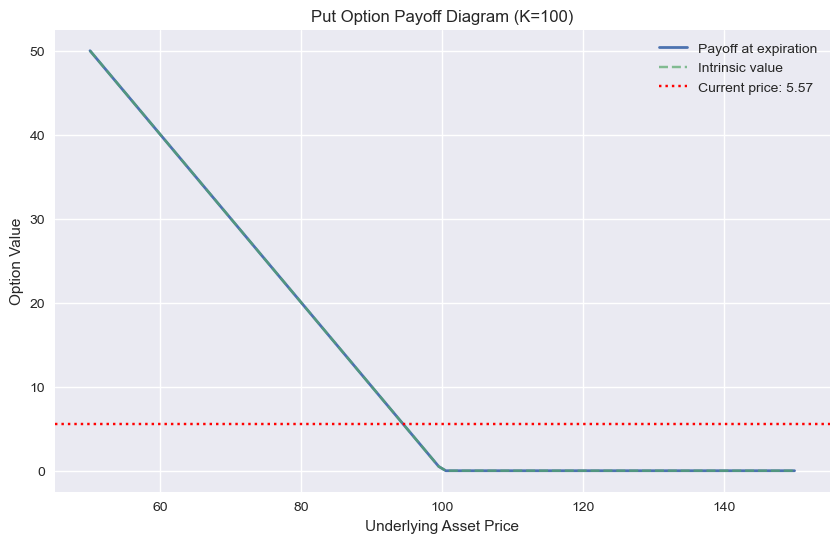

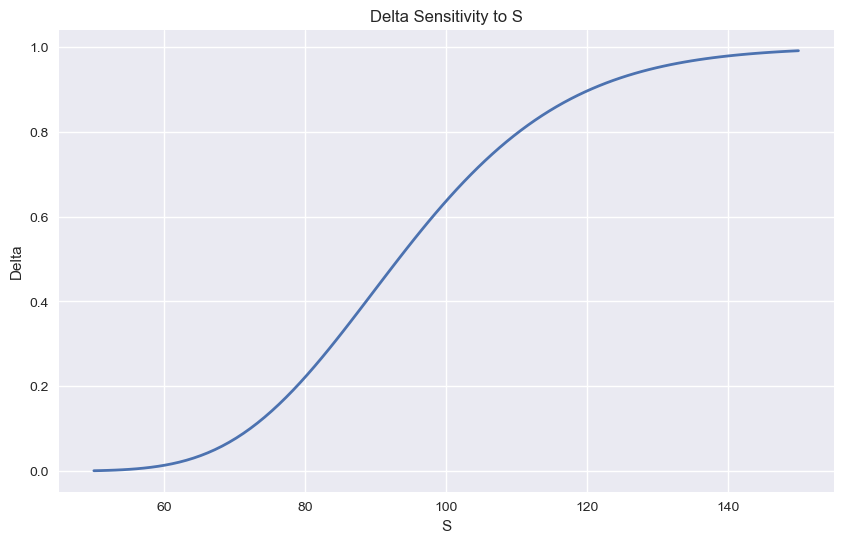

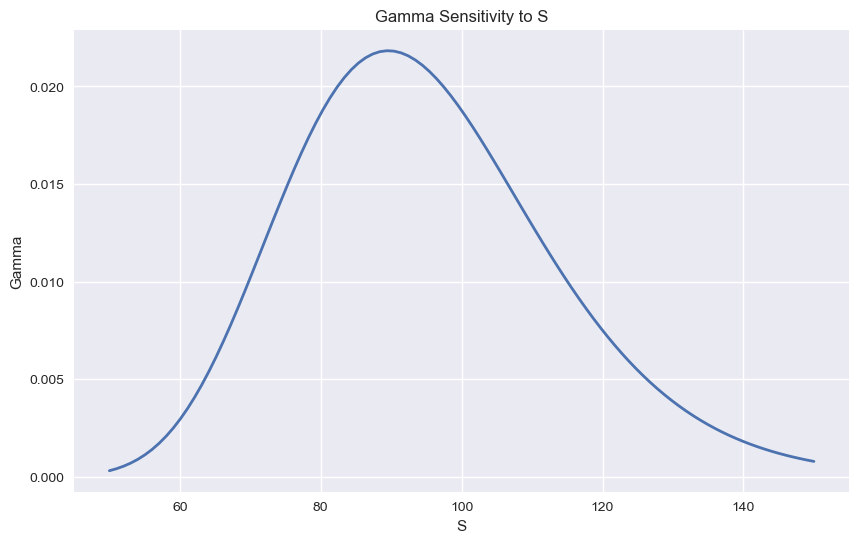

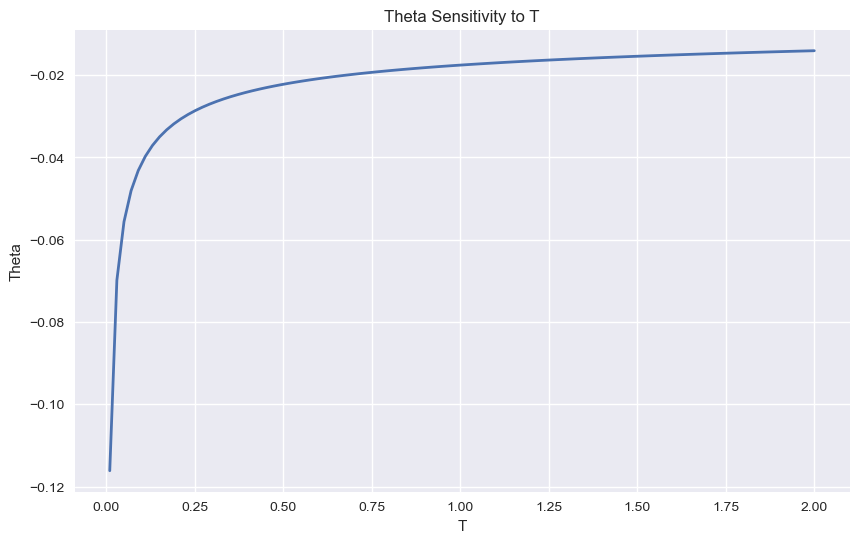

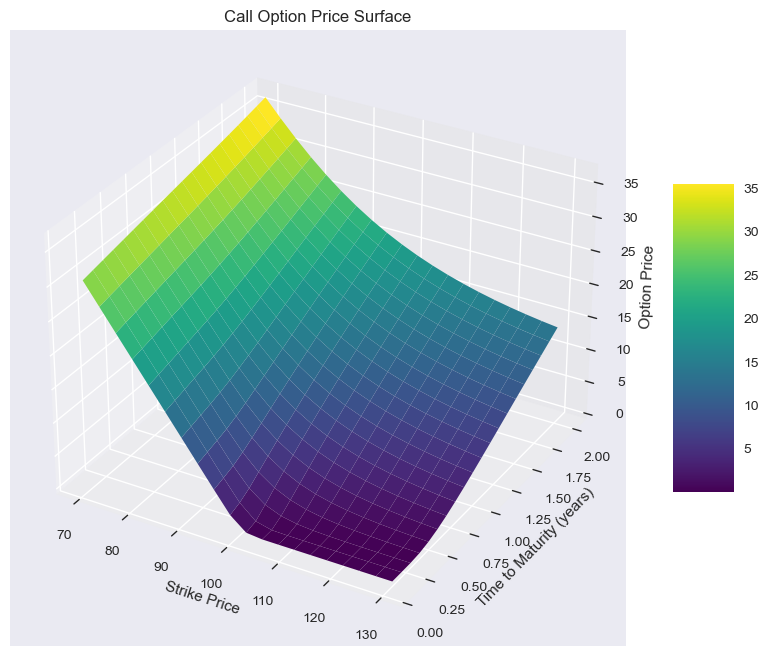

In [20]:
# Example usage
if __name__ == "__main__":
    # Parameters
    S = 100      # Current stock price
    K = 100      # Strike price
    T = 1.0      # Time to maturity (1 year)
    r = 0.05     # Risk-free rate (5%)
    sigma = 0.2  # Volatility (20%)
    
    # Calculate prices
    call_price_bs = black_scholes_price(S, K, T, r, sigma, 'call')
    put_price_bs = black_scholes_price(S, K, T, r, sigma, 'put')
    call_price_bt = binomial_tree_price(S, K, T, r, sigma, 'call')
    put_price_bt = binomial_tree_price(S, K, T, r, sigma, 'put')
    
    print(f"Call Price (Black-Scholes): {call_price_bs:.2f}")
    print(f"Put Price (Black-Scholes): {put_price_bs:.2f}")
    print(f"Call Price (Binomial Tree): {call_price_bt:.2f}")
    print(f"Put Price (Binomial Tree): {put_price_bt:.2f}")
    
    # Calculate and print Greeks
    call_greeks = create_greeks_report(S, K, T, r, sigma, 'call')
    print("\nCall Option Greeks:")
    for greek, value in call_greeks.items():
        print(f"{greek.capitalize()}: {value:.4f}")
    
    # Plot payoff diagrams
    plot_payoff_diagram(S, K, T, r, sigma, 'call')
    plot_payoff_diagram(S, K, T, r, sigma, 'put')
    
    # Plot Greek sensitivities
    plot_greek_sensitivity(calculate_delta, S, K, T, r, sigma, 'call', 'S')
    plot_greek_sensitivity(calculate_gamma, S, K, T, r, sigma, 'call', 'S')
    plot_greek_sensitivity(calculate_theta, S, K, T, r, sigma, 'call', 'T')
    
    # Plot volatility surface
    plot_volatility_surface(S, K, np.linspace(0.1, 2, 20), r, 'call')